In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('data/melb_data.csv')
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [5]:
data.dropna(axis=0, subset=['Price'], inplace=True)

#features = ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Lattitude', 'Longtitude']
#X = data[features]

#Work only with numerical features
features = data.drop(['Price'], axis=1)
X = features.select_dtypes(exclude=['object'])

y = data.Price

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [62]:
# Deal with missing values in X_train
from sklearn.impute import SimpleImputer

#Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

#Put column names back in
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

imputed_X_valid

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,4.0,8.0,3016.0,4.0,2.0,2.0,450.0,190.000000,1910.000000,-37.86100,144.89850,6380.0
1,2.0,6.6,3011.0,2.0,1.0,0.0,172.0,81.000000,1900.000000,-37.81000,144.88960,2417.0
2,3.0,10.5,3020.0,3.0,1.0,1.0,581.0,154.655601,1964.938304,-37.76740,144.82421,4217.0
3,3.0,4.5,3181.0,2.0,2.0,1.0,128.0,134.000000,2000.000000,-37.85260,145.00710,7717.0
4,3.0,8.5,3044.0,3.0,2.0,2.0,480.0,154.655601,1964.938304,-37.72523,144.94567,7485.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3390,3.0,27.0,3196.0,3.0,1.0,3.0,694.0,136.000000,1975.000000,-38.03819,145.12443,2546.0
3391,3.0,3.5,3068.0,3.0,1.0,0.0,275.0,116.000000,1915.000000,-37.77790,144.98620,6244.0
3392,4.0,12.4,3108.0,4.0,2.0,2.0,493.0,154.655601,1964.938304,-37.78457,145.10453,9028.0
3393,3.0,5.9,3032.0,3.0,1.0,3.0,0.0,154.655601,1972.000000,-37.77230,144.90940,6567.0


In [8]:
#Use XGBoost to fit model
!conda install xgboost -y #The -y gives an automatic "Yes" answer when asked "Proceed ([y]/n)?" during the installation
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

my_model.fit(imputed_X_train, y_train)

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          13 KB
    certifi-2024.8.30          |  py312hca03da5_0         164 KB
    libxgboost-2.1.1           |       h313beb8_0         1.8 MB
    py-xgboost-2.1.1           |  py312hca03da5_0         365 KB
    xgboost-2.1.1              |  py312hca03da5_0          12 KB
    yfinance-0.2.43            |     pyhd8ed1ab_0          72 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  pkgs/main/osx-arm64::_py-xgboost-mutex-2.0-cpu_0 
  libxgboost       

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
#Compute MAE of model
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(my_model.predict(imputed_X_valid),y_valid)
mae

166757.52632547866

### Improving the model

In [61]:
import numpy as np
def get_score(n_estimators, learning_rate):
    
    my_model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=8)
    my_model.fit(imputed_X_train, y_train,
                #  eval_set=[(imputed_X_valid, y_valid)],
                # early_stopping_rounds=5,
                verbose=False)

    mae = mean_absolute_error(my_model.predict(imputed_X_valid),y_valid)
    return mae
    

results = {(n_estimators, learning_rate): get_score(n_estimators,learning_rate)
           for n_estimators in range(1000, 10000, 1000) for learning_rate in np.arange(0.05,0.30, step=0.05)
          }


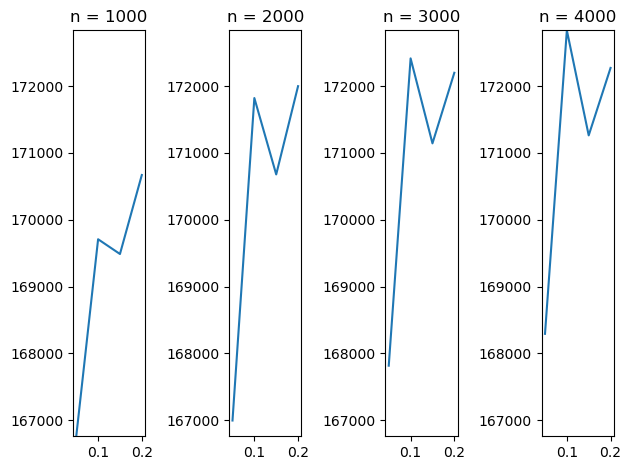

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



n_estimators_values = list(range(1000, 5000, 1000))
learning_rate_values = list(np.arange(0.05,0.20, step=0.05))

n = len(n_estimators_values)
fig, axs = plt.subplots(1, n)
axs = axs.flatten()

all_y_values = []
for n_estimators in n_estimators_values:
    for lr in learning_rate_values:
        all_y_values.append(results[(n_estimators, lr)])
y_min = min(all_y_values)
y_max = max(all_y_values)


for i, n_estimators in enumerate(n_estimators_values):
    ax = axs[i]
    y = [results[(n_estimators,learning_rate)] for learning_rate in learning_rate_values]
    ax.plot(learning_rate_values, y)
    ax.set_title(f'n = {n_estimators}')
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

    

# N_estimators_values, Learning_rate_values = np.meshgrid(n_estimators_values,learning_rate_values)

# Z = np.array(list(results.values())).reshape(len(n_estimators_values), len(Learning_rate_values))

# N_estimators_values_flat = N_estimators_values.flatten()
# Learning_rate_flat = Learning_rate_values.flatten()
# Z_flat = Z.flatten()

# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Create the scatter plot
# sc = ax.scatter(N_estimators_values_flat, Learning_rate_flat, Z_flat, c=Z_flat, cmap='viridis')

# plt.colorbar(sc, label='Z value')

# ax.set_xlabel('n_estimators')
# ax.set_ylabel('learning rate')
# ax.set_zlabel('MAE')

# plt.show()